<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/CNN%20Ensemble/VGGnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"

Cloning into 'EC523-Deep-Learning-Project'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 120 (delta 36), reused 6 (delta 1), pack-reused 40
Receiving objects: 100% (120/120), 180.52 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
!pip install unrar

In [ ]:
# !unrar x "EC523-Deep-Learning-Project/datasets/ckplus.rar"
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


##Imports

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [ ]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

transform = transforms.Normalize(mean=129.4456, std = 1)

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [ ]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample

mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
                    transforms.RandomAffine(0, translate=(0, 0.1)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

    Sad Neutral   Angry Neutral   Angry


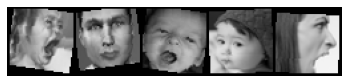

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

In [ ]:
# import VGG model

import torchvision.models as models
vgg = models.vgg19(pretrained=True).features
vgg.to(device)
vgg.eval()   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# # create a module to normalize input image so we can easily put it in a nn.Sequential
# class Normalization(nn.Module):
#     def __init__(self, mean, std):
#         super(Normalization, self).__init__()    
#         self.mean = mean.clone().detach()
#         self.std = std.clone().detach()

#     def forward(self, img):
#         # normalize img
#         mean = self.mean.view(-1, 1, 1)
#         std = self.std.view(-1, 1, 1)
#         normalized_img = (img - mean)/std ## -- ! code required  
#         return normalized_img

# normalization = Normalization(normalization_mean, normalization_std).to(device)
# model = nn.Sequential(normalization)

In [ ]:

# revise vgg model

class reVgg(nn.Module):
  def __init__(self, vgg):
    super(reVgg, self).__init__()
    self.convert = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
    self.vgg = vgg
    self.lin1= nn.Linear(512 * 1 * 1, 7)
    self.history = History()
  def forward(self, x):
    x = self.convert(x)
    x = self.vgg(x)
    x = x.view(-1, 512 * 1 * 1)
    x = self.lin1(x)
    return x

##Model

In [ ]:
class History:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

### Subnets

##Training

In [ ]:
def train_model(net, trainloader, valloader, n_epochs=20):

    for epoch in range(n_epochs):
        
        net = net.train()
        loss_tr, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_tr += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_tr = 100 * correct_count / n
        loss_tr = loss_tr / n

        acc_v, loss_v = test_model(net, valloader)

        net.history.loss_train.append(loss_tr)
        net.history.loss_val.append(loss_v)

        net.history.acc_train.append(acc_tr)
        net.history.acc_val.append(acc_v)
        
        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_tr), 'Val Accuracy: %2.2f %%' % (acc_v), sep='\t\t')

In [ ]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [ ]:
model = reVgg(cnn)
model = model.to(device)

In [ ]:
# sub2 = Subnet2()
# sub2 = sub2.to(device)

In [ ]:
# sub3 = Subnet3()
# sub3 = sub3.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_model(model, trainloader, valloader, n_epochs= 43)

Epoch  1		Train Accuracy: 90.81 %		Val Accuracy: 67.99 %
Epoch  2		Train Accuracy: 90.75 %		Val Accuracy: 68.49 %
Epoch  3		Train Accuracy: 90.62 %		Val Accuracy: 68.40 %
Epoch  4		Train Accuracy: 90.95 %		Val Accuracy: 66.93 %
Epoch  5		Train Accuracy: 91.41 %		Val Accuracy: 68.04 %
Epoch  6		Train Accuracy: 90.27 %		Val Accuracy: 67.82 %
Epoch  7		Train Accuracy: 91.45 %		Val Accuracy: 68.35 %
Epoch  8		Train Accuracy: 91.74 %		Val Accuracy: 68.21 %
Epoch  9		Train Accuracy: 91.99 %		Val Accuracy: 67.46 %
Epoch 10		Train Accuracy: 92.24 %		Val Accuracy: 68.21 %
Epoch 11		Train Accuracy: 92.30 %		Val Accuracy: 68.74 %
Epoch 12		Train Accuracy: 92.54 %		Val Accuracy: 67.57 %
Epoch 13		Train Accuracy: 92.43 %		Val Accuracy: 66.20 %
Epoch 14		Train Accuracy: 92.34 %		Val Accuracy: 67.18 %
Epoch 15		Train Accuracy: 92.83 %		Val Accuracy: 68.85 %
Epoch 16		Train Accuracy: 92.76 %		Val Accuracy: 67.99 %
Epoch 17		Train Accuracy: 93.23 %		Val Accuracy: 68.15 %
Epoch 18		Train Accuracy: 93.29

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, trainloader, valloader, n_epochs=20)

Epoch  1		Train Accuracy: 97.25 %		Val Accuracy: 69.94 %
Epoch  2		Train Accuracy: 97.81 %		Val Accuracy: 70.08 %
Epoch  3		Train Accuracy: 97.93 %		Val Accuracy: 69.88 %
Epoch  4		Train Accuracy: 98.02 %		Val Accuracy: 69.94 %
Epoch  5		Train Accuracy: 98.18 %		Val Accuracy: 70.10 %
Epoch  6		Train Accuracy: 98.23 %		Val Accuracy: 70.27 %
Epoch  7		Train Accuracy: 98.21 %		Val Accuracy: 70.02 %
Epoch  8		Train Accuracy: 98.25 %		Val Accuracy: 70.33 %
Epoch  9		Train Accuracy: 98.27 %		Val Accuracy: 70.33 %
Epoch 10		Train Accuracy: 98.29 %		Val Accuracy: 70.33 %
Epoch 11		Train Accuracy: 98.37 %		Val Accuracy: 70.52 %
Epoch 12		Train Accuracy: 98.30 %		Val Accuracy: 70.38 %
Epoch 13		Train Accuracy: 98.26 %		Val Accuracy: 70.19 %
Epoch 14		Train Accuracy: 98.44 %		Val Accuracy: 70.08 %
Epoch 15		Train Accuracy: 98.46 %		Val Accuracy: 69.71 %
Epoch 16		Train Accuracy: 98.45 %		Val Accuracy: 70.27 %
Epoch 17		Train Accuracy: 98.44 %		Val Accuracy: 69.80 %
Epoch 18		Train Accuracy: 98.50

##Evaluation

In [ ]:
def plot_metrics(net):
    plt.figure()
    plt.plot(net.history.acc_train, 'g', label='Training Acc')
    plt.plot(net.history.acc_val, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(net.history.loss_train, 'g', label='Training Loss')
    plt.plot(net.history.loss_val, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('Training Accuracy: %2.2f %%' % (max(net.history.acc_train)))
    print('Validation Accuracy: %2.2f %%' % (max(net.history.acc_val)))
    print()

    acc, loss = test_model(net, testloader)    
    print('Test Accuracy: %2.2f %%' % (acc))
    print('Average Test Loss: %2.4f' % (loss))
    

VGG model


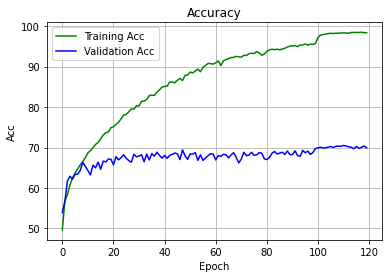

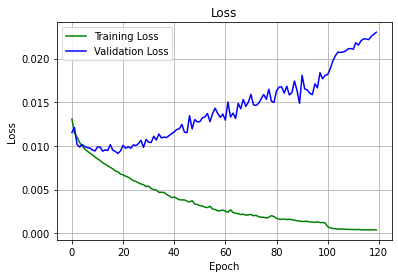

Training Accuracy: 98.50 %
Validation Accuracy: 70.52 %

Test Accuracy: 68.68 %
Average Test Loss: 0.0245


In [ ]:
print("VGG model")
plot_metrics(model) 

### Subnets

In [ ]:
print("Subnet 1")
plot_metrics(sub1) 

Subnet 1


NameError: ignored

In [ ]:
path = 'VGG'
torch.save(model.state_dict(), path)

Subnet 2


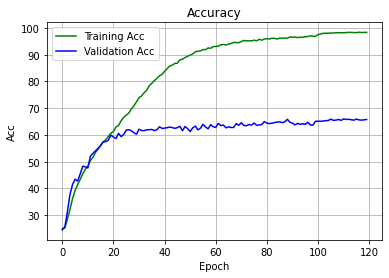

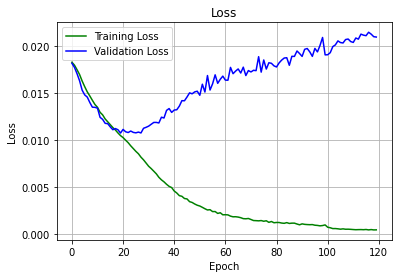

Training Accuracy: 98.39 %
Validation Accuracy: 65.98 %

Test Accuracy: 64.39 %
Average Test Loss: 0.0229


In [ ]:
print("Subnet 2")
plot_metrics(sub2)

Subnet 3


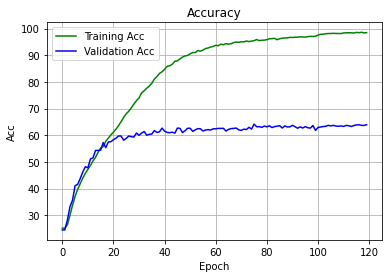

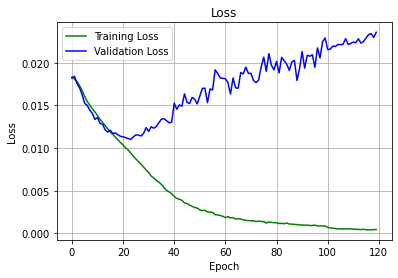

Training Accuracy: 98.61 %
Validation Accuracy: 64.17 %

Test Accuracy: 64.22 %
Average Test Loss: 0.0247


In [ ]:
print("Subnet 3")
plot_metrics(sub3)

##Save Model

In [ ]:
path = 'sub3'
torch.save(sub3.state_dict(), path)

In [ ]:
# from google.colab import files
# files.download(path)